<a href="https://colab.research.google.com/github/Og31330/SHSPublic/blob/main/Trajectory_softmax_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trajectory
Inspired from fiddle

Using tracknet dataset

In [729]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [730]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import kde

import pandas as pd
import glob
import h5py, json
import os,time,sys
import math, random

# Analyze raw data

## Create dataset

In [731]:
# FILL WITH DATA SET PATH
#create data set
#df = pd.read_csv(f'/content/gdrive/MyDrive/DataSet_Training/Tracknet/game6/Clip1/Label.csv', header=0, sep=',')
all_files = glob.glob(os.path.join('/content/gdrive/MyDrive/DataSet_Training/Tracknet/csv', "*.csv"))
df = pd.concat((pd.read_csv(f, header=0, sep=',') for f in all_files), ignore_index=True)

## Analyze dataset

In [732]:
# analysze panda structure

# ---- Get the columns name as descriptions
synop_desc = list(df.columns)
# ---- Count the na values by columns
columns_na = df.isna().sum().tolist()

print("Dataset legnth = ", df.shape[0])
print("Colums = ", synop_desc)
print ("Nan values = ", columns_na)
display(df.tail(5))


Dataset legnth =  19835
Colums =  ['file name', 'visibility', 'x-coordinate', 'y-coordinate', 'status']
Nan values =  [0, 0, 729, 729, 729]


,file name,visibility,x-coordinate,y-coordinate,status
19830,0581.jpg,1,238.0,478.0,0.0
19831,0582.jpg,1,222.0,492.0,0.0
19832,0583.jpg,1,205.0,512.0,0.0
19833,0584.jpg,1,190.0,530.0,0.0
19834,0585.jpg,1,172.0,550.0,0.0


         visibility  x-coordinate  y-coordinate        status
count  19835.000000  19106.000000  19106.000000  19106.000000
mean       1.041694    640.280383    246.757354      0.081754
std        0.348907    149.493762    136.315541      0.360312
min        0.000000      3.000000      2.000000      0.000000
25%        1.000000    538.000000    141.000000      0.000000
50%        1.000000    638.000000    217.000000      0.000000
75%        1.000000    741.000000    333.000000      0.000000
max        3.000000   1279.000000    720.000000      2.000000


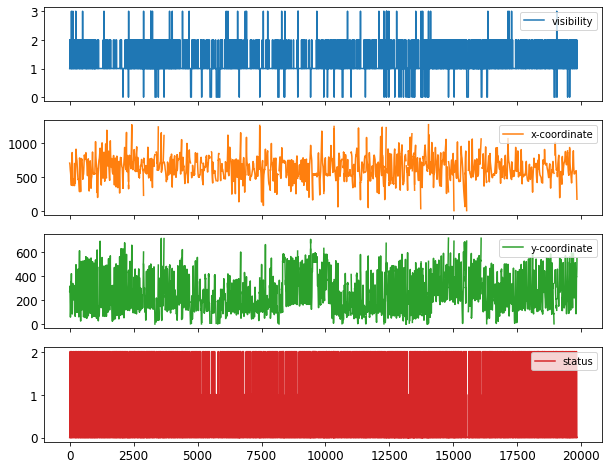

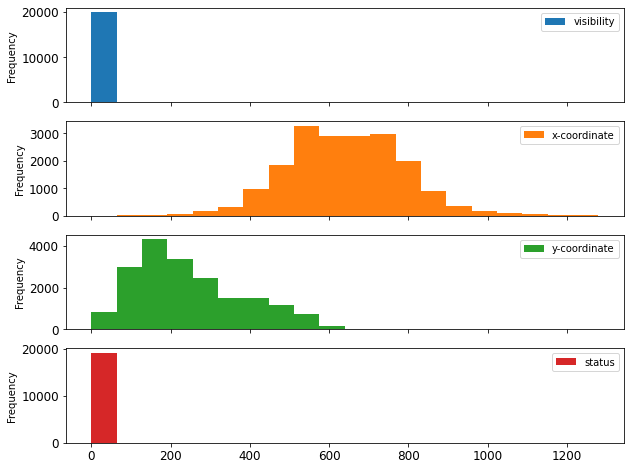

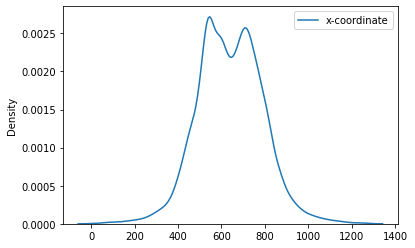

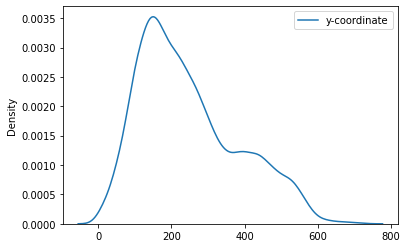

In [733]:
# ---- Data set analysis
print(df.describe())
df.iloc[:].plot(subplots=True, fontsize=12, figsize=(10,8))
df.plot.hist(subplots=True, bins = 20, fontsize=12, figsize=(10,8))
plt.show()
sns.kdeplot(data=df[['x-coordinate']])
plt.show()
sns.kdeplot(data=df[['y-coordinate']])
plt.show()

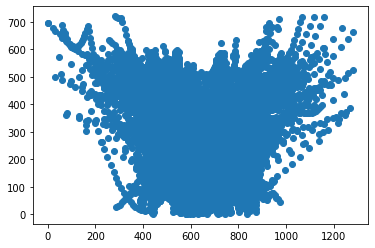

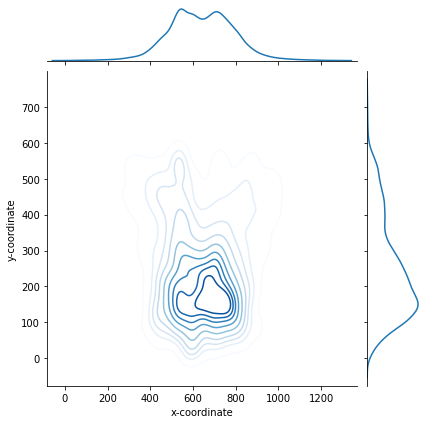

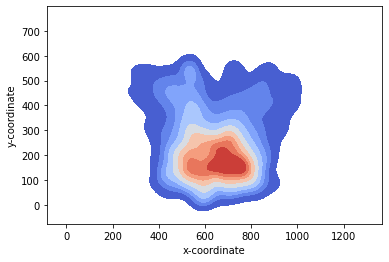

In [734]:
# Image density analysis for relevant columns x-coordinate &  y-coordinate
dfImg=df[['x-coordinate', 'y-coordinate']]
x = np.asarray(df.loc[ :, ['x-coordinate'] ])
y = np.asarray(df.loc[ :, ['y-coordinate'] ])
# Everything starts with a Scatterplot
plt.scatter(x, y)
plt.show()
# Créer une heatmap de la densité de probabilité à deux dimensions des colonnes "colonne_1" et "colonne_2" de la DataFrame df
sns.jointplot(x='x-coordinate', y='y-coordinate', data=df, kind='kde', cmap='Blues')
plt.show()
# Créer une heatmap à partir de la DataFrame df avec les colonnes "x" et "y" représentant les coordonnées des points
heatmap = sns.kdeplot(data=df, x="x-coordinate", y="y-coordinate", cmap="coolwarm", shade=True)
plt.show()

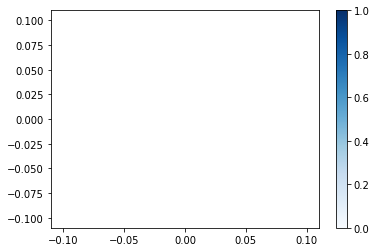

In [735]:
dfImg=df[['x-coordinate', 'y-coordinate']]
x = np.asarray(df.loc[ :, ['x-coordinate'] ])
y = np.asarray(df.loc[ :, ['y-coordinate'] ])
plt.hexbin(x, y, gridsize=20, cmap='Blues', mincnt=1)
plt.colorbar()


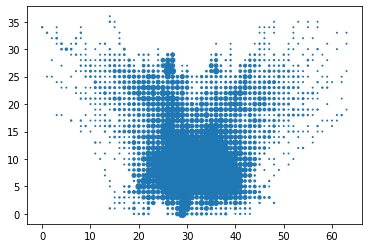

In [736]:
# Diviser les valeurs de votre dataframe en zones

df['zone_x'] = df['x-coordinate'] // 20
df['zone_y'] = df['y-coordinate'] // 20

# Calculer la densité de points pour chaque zone
density = df.groupby(['zone_x', 'zone_y']).size().reset_index(name='count')

# Afficher la densité de points pour chaque zone
plt.scatter(density['zone_x'], density['zone_y'], s=density['count'], cmap='Blues')

# Clean dataset

In [737]:
# ---- Clean Lines with NaN
na_rows=df.isna().any(axis=1)
display( df[na_rows].head(5) )

# ---- Nice linear interpolation for plugging holes
df.interpolate(method='linear', inplace=True)

# ---- After
display(df[na_rows].head(5))

,file name,visibility,x-coordinate,y-coordinate,status,zone_x,zone_y
2082,0411.jpg,0,NaN,NaN,NaN,NaN,NaN
2083,0412.jpg,0,NaN,NaN,NaN,NaN,NaN
2084,0413.jpg,0,NaN,NaN,NaN,NaN,NaN
2296,0074.jpg,0,NaN,NaN,NaN,NaN,NaN
2297,0075.jpg,0,NaN,NaN,NaN,NaN,NaN


,file name,visibility,x-coordinate,y-coordinate,status,zone_x,zone_y
2082,0411.jpg,0,337.75,627.25,0.0,16.25,30.75
2083,0412.jpg,0,339.50,624.50,0.0,16.50,30.50
2084,0413.jpg,0,341.25,621.75,0.0,16.75,30.25
2296,0074.jpg,0,428.60,435.00,0.0,21.20,21.00
2297,0075.jpg,0,415.20,436.00,0.0,20.40,21.00


In [738]:
# on ajoute les classes
df.insert(5, 'fly', 0)
df.insert(5, 'rebound', 0)
df.insert(5, 'hit', 0)
#df[df > 0] = 1

In [739]:
df['fly'] = df.apply(lambda x: 1 if x['status'] == 0 else 0, axis = 1)
df['rebound'] = df.apply(lambda x: 1 if x['status'] == 2 else 0, axis = 1)
df['hit'] = df.apply(lambda x: 1 if x['status'] == 1 else 0, axis = 1)

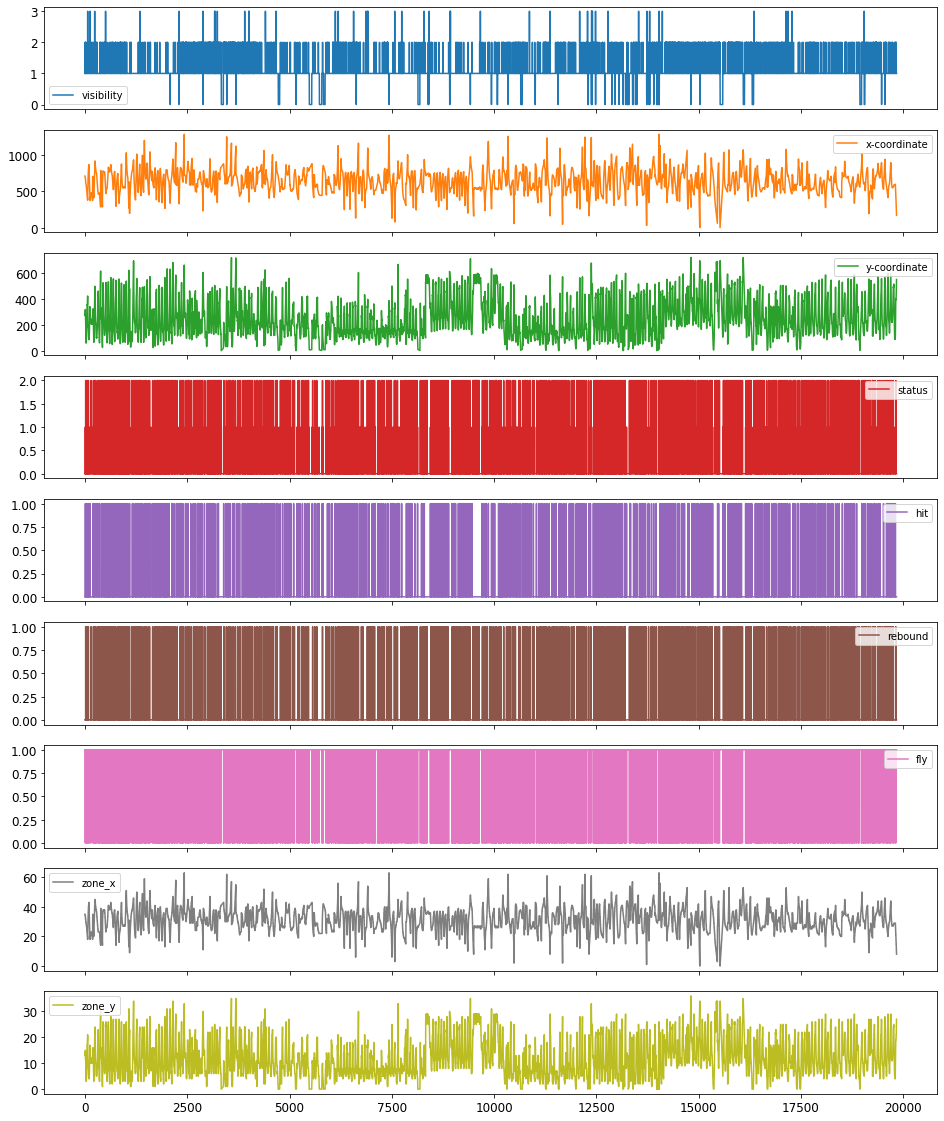

In [740]:
df.iloc[0:len(df)].plot(subplots=True, fontsize=12, figsize=(16,20))
#df.iloc[0:500].plot(subplots=True, fontsize=12, figsize=(16,20))
plt.show()

# Train the model

###Prepare dataset for training

In [741]:
# ---- About training (Can be changed !)
#
scale            = 1       # Percentage of dataset to be used (1=all)
train_prop       = .75       # Percentage for train (the rest being for the test)
val_prop         = 0.2
test_prop        = 0.05
class0_prop      = 0.9  # proportion de flying ball en plus pour dicretiser avec les autres au mieux
bef_rebound_len = 5
post_rebound_length = 5
sequence_len     = post_rebound_length + bef_rebound_len
sequence_class_len = post_rebound_length + bef_rebound_len
batch_size       = 32
epochs           = 500
iterations       = 5        # number of iterations for prediction 

In [742]:
# ---- About input dataset (no need to change)
#
features         = ['x-coordinate', 'y-coordinate']
features_len     = len(features)
print(features_len)
#features_class         = ['fly', 'rebound', 'hit']
features_class         = ['status']
features_class_len     = len(features_class)
print(features_class_len)

2
1


In [743]:
# convertions to numpy arry on selected colums and class
df_points = df.loc[ :, features ]
df_class  = df.loc[:,    features_class ]
print('Train class dataset example :')
display(df_points.head(3))
display(df_class.head(3))

points = df_points.to_numpy()
class_obj  = df_class.to_numpy()

print('Points       : ',points.shape)
print('Class : ', class_obj.shape)

Train class dataset example :


,x-coordinate,y-coordinate
0,708.0,274.0
1,706.0,274.0
2,703.0,276.0


,status
0,0.0
1,0.0
2,0.0


Points       :  (19835, 2)
Class :  (19835, 1)


### Add fly, hit and rebound series

In [744]:
# create dataset
dataset = []
dataset_class = []

In [745]:
#dataset generator (timeseries custo). on ajoute tous les rebound
x = []
y = []
v = []
for i in range (bef_rebound_len, len(class_obj)-1-2*sequence_len):
  if class_obj[i][0]==2:
    v = points[i-bef_rebound_len : i+post_rebound_length]
    x.append(v)  
    y.append(class_obj[i]) 

print(f'Nombre de timeseries disponibles : ', len(x))
print('Batch timeserie shape : ',np.asarray(x).shape)


Nombre de timeseries disponibles :  522
Batch timeserie shape :  (522, 10, 2)


In [746]:
#dataset generator (timeseries custo). on ajoute tous les fly e mm qt
for i in range (bef_rebound_len, len(class_obj)-1-2*sequence_len, int(class0_prop*len(class_obj)/len(x))):
  if class_obj[i][0]==0:
    v = points[i-bef_rebound_len : i+post_rebound_length]
    x.append(v)  
    y.append(class_obj[i])  
  else: # add next node
    v = points[i-bef_rebound_len : i+post_rebound_length]
    x.append(v)   
    y.append(class_obj[i+1]) 

print(f'Nombre de timeseries disponibles : ', len(x))
print('Batch timeserie shape : ',np.asarray(x).shape)

Nombre de timeseries disponibles :  1105
Batch timeserie shape :  (1105, 10, 2)


In [747]:
#dataset generator (timeseries custo). on ajoute tous les rebound
for i in range (bef_rebound_len, len(class_obj)-1-2*sequence_len):
  if class_obj[i][0]==1:
    v = points[i-bef_rebound_len : i+post_rebound_length]
    x.append(v)  
    y.append(class_obj[i]) 

print(f'Nombre de timeseries disponibles : ', len(x))
print('Batch timeserie shape : ',np.asarray(x).shape)

Nombre de timeseries disponibles :  1621
Batch timeserie shape :  (1621, 10, 2)


In [748]:
dataset = np.asarray(x)
dataset_class = np.asarray(y)

print(f'Nombre de timeseries disponibles : ', len(dataset))
print('batch timeserie shape : ',dataset.shape)
print('batch class shape : ',dataset_class.shape)
print('What a timeseries batch looks like :')
print(dataset[0] )
print('What a class batch looks like :')
print(dataset_class[0])

Nombre de timeseries disponibles :  1621
batch timeserie shape :  (1621, 10, 2)
batch class shape :  (1621, 1)
What a timeseries batch looks like :
[[659. 257.]
 [652. 245.]
 [642. 237.]
 [634. 230.]
 [630. 224.]
 [625. 221.]
 [620. 208.]
 [614. 179.]
 [612. 156.]
 [608. 138.]]
What a class batch looks like :
[2.]


### On mélange

In [749]:
# Générer un tableau de permutations aléatoires des indices
permutation = np.random.permutation(len(dataset))
print("Avant permutation:")
print(dataset[permutation[5]])
print(dataset_class[permutation[5]])
    
# Réorganiser les deux tableaux selon la permutation aléatoire
dataset = dataset[permutation]
dataset_class = dataset_class[permutation]

print("\nAprès permutation:")
print(f'Nombre de timeseries disponibles : ', len(dataset))
print('batch timeserie shape : ',dataset.shape)
print('batch class shape : ',dataset_class.shape)
print('What a timeseries batch looks like :')
print(dataset[5] )
print('What a class batch looks like :')
print(dataset_class[5])

# Utiliser numpy.unique() pour trouver les valeurs uniques et leur nombre d'occurrences respectif
valeurs_uniques, nb_occurrences = np.unique(dataset_class, return_counts=True)
# Afficher les résultats
for i, valeur in enumerate(valeurs_uniques):
    print("La class", valeur, "apparaît", nb_occurrences[i], "fois dans le dataset.")

Avant permutation:
[[761. 153.]
 [768. 152.]
 [775. 155.]
 [781. 155.]
 [788. 156.]
 [793. 160.]
 [794. 148.]
 [799. 138.]
 [804. 129.]
 [804. 123.]]
[2.]

Après permutation:
Nombre de timeseries disponibles :  1621
batch timeserie shape :  (1621, 10, 2)
batch class shape :  (1621, 1)
What a timeseries batch looks like :
[[761. 153.]
 [768. 152.]
 [775. 155.]
 [781. 155.]
 [788. 156.]
 [793. 160.]
 [794. 148.]
 [799. 138.]
 [804. 129.]
 [804. 123.]]
What a class batch looks like :
[2.]
La class 0.0 apparaît 582 fois dans le dataset.
La class 1.0 apparaît 517 fois dans le dataset.
La class 2.0 apparaît 522 fois dans le dataset.


# Build Train and Test dataset

In [750]:
# ---- Scaling

dataset = dataset[:int(scale*len(df))]
dataset_class = dataset_class[:int(scale*len(df))]
train_len=int(train_prop*len(dataset))
val_len=int(val_prop*len(dataset))

# ---- Train / Val / Test
dataset_train = dataset[ :train_len-1,:]
dataset_val  = dataset[train_len:train_len+val_len-1, : ]
dataset_test  = dataset[train_len+val_len:, : ]
print('Train dataset example :')
print(dataset_train[0])

# ---- Class Train / Test
dataset_class_train = dataset_class[ :train_len-1,:]
dataset_class_val  = dataset_class[train_len:train_len+val_len-1, : ]
dataset_class_test  = dataset_class[train_len+val_len:, : ]
print('Train class dataset example :')
print(dataset_class_train[0])

#check result
print('Full dataset : ',dataset.shape)
print('Train dataset : ',dataset_train.shape)
print('Trains Class dataset : ',dataset_class_train.shape)
print('Val dataset : ',dataset_val.shape)
print('Val Class dataset : ',dataset_class_val.shape)
print('Test dataset : ',dataset_test.shape)
print('Test Class dataset : ',dataset_class_test.shape)

Train dataset example :
[[490. 103.]
 [486. 100.]
 [476.  96.]
 [468.  97.]
 [465.  95.]
 [455.  94.]
 [456.  95.]
 [450.  95.]
 [442.  96.]
 [436. 100.]]
Train class dataset example :
[0.]
Full dataset :  (1621, 10, 2)
Train dataset :  (1214, 10, 2)
Trains Class dataset :  (1214, 1)
Val dataset :  (323, 10, 2)
Val Class dataset :  (323, 1)
Test dataset :  (82, 10, 2)
Test Class dataset :  (82, 1)


## Normalize

In [751]:
# ---- Normalize dataset
mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_val  = (dataset_val  - mean) / std
dataset_test  = (dataset_test  - mean) / std

print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_val.shape)
print('Test  dataset : ',dataset_test.shape)
print('Train  mean : ',dataset_train.mean())
print('Train  std : ',dataset_train.std())
print('Train  min : ',dataset_train.min())
print('Train  max : ',dataset_train.max())

Train dataset :  (1214, 10, 2)
Test  dataset :  (323, 10, 2)
Test  dataset :  (82, 10, 2)
Train  mean :  2.8737766330989226e-16
Train  std :  0.9999999999999999
Train  min :  -1.8635733578672173
Train  max :  3.3104360504061914


In [752]:
#from keras.utils.np_utils import to_categorical
#test_class_batch = to_categorical(test_class_batch)

# Create model

In [753]:
%mkdir (/content/run)

/bin/bash: -c: line 0: syntax error near unexpected token `/content/run'
/bin/bash: -c: line 0: `mkdir (/content/run)'


In [754]:
save_dir = f'/content/run/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [755]:
#create model
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.GRU(30, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(3, activation='softmax') )
model.output_shape
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 30)                3060      
                                                                 
 dropout_23 (Dropout)        (None, 30)                0         
                                                                 
 dense_23 (Dense)            (None, 3)                 93        
                                                                 
Total params: 3,153
Trainable params: 3,153
Non-trainable params: 0
_________________________________________________________________


In [756]:
#compile model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics   = ['accuracy'] )

#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics   = ['accuracy'] )
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics   = ['accuracy'] )
#model.compile(optimizer='adam', loss='mse', metrics   = ['mae'] )

In [757]:
history = model.fit(dataset_train, dataset_class_train, epochs  = 700,  batch_size = batch_size, validation_data = (dataset_val, dataset_class_val), callbacks = [bestmodel_callback])

Epoch 1/700
38/38 [==============================] - 5s 23ms/step - loss: 1.1109 - accuracy: 0.3394 - val_loss: 1.0959 - val_accuracy: 0.3777
Epoch 2/700
38/38 [==============================] - 0s 9ms/step - loss: 1.0944 - accuracy: 0.3822 - val_loss: 1.0900 - val_accuracy: 0.3870
Epoch 3/700
38/38 [==============================] - 0s 9ms/step - loss: 1.0934 - accuracy: 0.3896 - val_loss: 1.0851 - val_accuracy: 0.3746
Epoch 4/700
38/38 [==============================] - 0s 9ms/step - loss: 1.0840 - accuracy: 0.4020 - val_loss: 1.0832 - val_accuracy: 0.3839
Epoch 5/700
38/38 [==============================] - 0s 10ms/step - loss: 1.0852 - accuracy: 0.3756 - val_loss: 1.0810 - val_accuracy: 0.3839
Epoch 6/700
38/38 [==============================] - 0s 10ms/step - loss: 1.0850 - accuracy: 0.4094 - val_loss: 1.0773 - val_accuracy: 0.3963
Epoch 7/700
38/38 [==============================] - 0s 12ms/step - loss: 1.0745 - accuracy: 0.4044 - val_loss: 1.0731 - val_accuracy: 0.3963
Epoch 8/7

# Prediction

## Analyze predictions

In [758]:
 loaded_model = tf.keras.models.load_model(f'/content/run/best_model.h5')

Matrice de confusion: (323, 10, 2)
11/11 [==============================] - 0s 3ms/step
(323,)


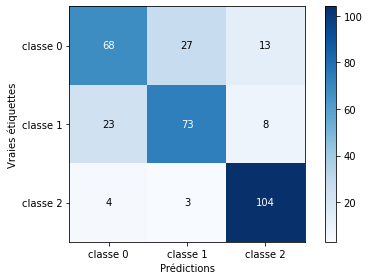

In [759]:
# Afficher la matrice de confusion sur les dataset val
print("Matrice de confusion:", dataset_val.shape)
pred = loaded_model.predict( dataset_val )
pred = np.argmax(pred, axis=1)
print(pred.shape)

# générer la matrice de confusion
cm = confusion_matrix(dataset_class_val, pred)

# afficher la matrice de confusion
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xlabel='Prédictions', ylabel='Vraies étiquettes')

# afficher les étiquettes des axes
tick_marks = np.arange(3)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(['classe 0', 'classe 1', 'classe 2'])
ax.set_yticklabels(['classe 0', 'classe 1', 'classe 2'])

# afficher les valeurs dans les cases
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

# ajuster la disposition
fig.tight_layout()

# afficher le graphique
plt.show()

Matrice de confusion: (82, 10, 2)
3/3 [==============================] - 0s 4ms/step


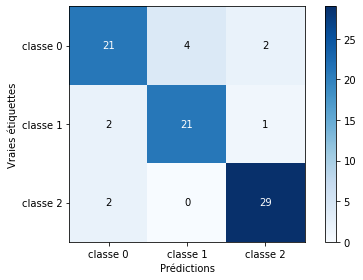

In [760]:
# Afficher la matrice de confusion sur les dataset test
print("Matrice de confusion:", dataset_test.shape)
pred = loaded_model.predict( dataset_test )
pred = np.argmax(pred, axis=1)

# générer la matrice de confusion
cm = confusion_matrix(dataset_class_test, pred)

# afficher la matrice de confusion
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xlabel='Prédictions', ylabel='Vraies étiquettes')

# afficher les étiquettes des axes
tick_marks = np.arange(3)
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(['classe 0', 'classe 1', 'classe 2'])
ax.set_yticklabels(['classe 0', 'classe 1', 'classe 2'])

# afficher les valeurs dans les cases
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

# ajuster la disposition
fig.tight_layout()

# afficher le graphique
plt.show()

## Test prediction

In [761]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s]
sequence_true = dataset_class_test[s]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
print (sequence)
print (sequence_true)
print(np.argmax(pred, axis=1))
print(pred)

1/1 [==============================] - 0s 26ms/step
[[ 0.96764459 -0.22444718]
 [ 0.9717838  -0.22030797]
 [ 0.97592301 -0.21616876]
 [ 0.97592301 -0.20375114]
 [ 0.98006221 -0.19133352]
 [ 0.98420142 -0.17477669]
 [ 0.98834063 -0.15408065]
 [ 0.99247984 -0.1292454 ]
 [ 0.99661904 -0.09613174]
 [ 1.00075825 -0.06301808]]
[0.]
[0]
[[0.9973355  0.00113206 0.00153238]]


# Denormalized test 

1/1 [==============================] - 0s 25ms/step
[[690.5     9.9  ]
 [687.875  10.075]
 [685.25   10.25 ]
 [682.625  10.425]
 [680.     10.6  ]
 [677.375  10.775]
 [674.75   10.95 ]
 [672.125  11.125]
 [669.5    11.3  ]
 [666.875  11.475]]
[0.]
[0]
[[9.7233790e-01 2.7480336e-02 1.8174481e-04]]


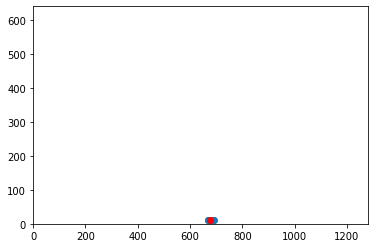

In [762]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence
i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i]
sequence_true = dataset_class_test[i]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization
sequence = denormalize(mean,std, sequence)

# ---- Show it
print(sequence)
print(sequence_true)
print(np.argmax(pred, axis=1))
print(pred)

#plot
x, y = np.split(sequence, 2, axis=1)
plt.scatter(x, y)
plt.scatter(x[bef_rebound_len], y[bef_rebound_len], color='red')
plt.axis([0, 1280, 0, 640])
plt.show()

1/1 [==============================] - 0s 29ms/step
[[177780.85467825  25336.21498765]
 [173915.38045472  26785.76782148]
 [169566.72195324  28476.91279427]
 [165459.65559074  30892.83418398]
 [161352.58922823  33067.16343472]
 [157003.93072676  35241.49268546]
 [152172.08794734  38865.37477002]
 [148306.61372381  41522.8882987 ]
 [143716.36308336  45388.36252223]
 [138884.52030394  48770.65246782]]
[0.]
[0]
[[1. 0. 0.]]


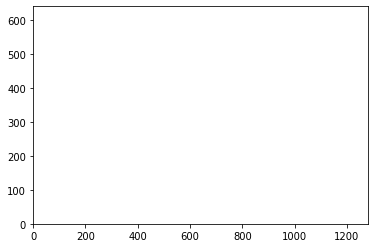

In [763]:
# KO - il faut normaliser - on prend n'importe quelle sequence au hazard, pas seulement celles construite pour le dataset stain
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence
i=random.randint(bef_rebound_len,len(dataset)-1-2*sequence_len)
sequence      = points[i-bef_rebound_len : i+post_rebound_length]
sequence_true = class_obj[i+bef_rebound_len]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization
sequence = denormalize(mean,std, sequence)

# ---- Show it
print(sequence)
print(sequence_true)
print(np.argmax(pred, axis=1))
print(pred)

#plot
x, y = np.split(sequence, 2, axis=1)
plt.scatter(x, y)
plt.scatter(x[bef_rebound_len], y[bef_rebound_len], color='red')
plt.axis([0, 1280, 0, 640])
plt.show()